This script collects data from Twitter's API to better understand how MPs interact with each other on the platform. The script then shows one way to visualise this data using the package networkx. 

In [1]:
# import packages
import tweepy 
import datetime
import pandas as pd
from collections import Counter
import networkx as nx
import matplotlib.pyplot
from matplotlib.lines import Line2D
import time

In [2]:
mp_details = pd.read_csv('https://github.com/hymeram/mp_twitter_networks/blob/main/MP_Twitter_Accounts_2021.csv?raw=true')
mp_details['username'] = mp_details['username'].str.lower() # screen names standardised to lower case 

screen_name_list = list(mp_details.username) # screen names of interest
screen_name_list = [x for x in screen_name_list if str(x) != 'nan'] # remove nan from list

mp_details.set_index('username', inplace=True)
mp_details.head()

,display_name,name,forename,surname,party,constituency,twitter,gender
username,,,,,,,,
nadams,Nigel Adams,Nigel Adams,Nigel,Adams,Conservative,Selby and Ainsty,https://twitter.com/nadams,male
bimafolami,Bim Afolami,Bim Afolami,Abimbola,Afolami,Conservative,Hitchin and Harpenden,https://twitter.com/BimAfolami,male
adamafriyie,Adam Afriyie,Adam Afriyie,Adam,Afriyie,Conservative,Windsor,https://twitter.com/AdamAfriyie,male
imranahmadkhan,Imran Ahmad Khan,Imran Ahmad Khan,Imran,Ahmad Khan,Conservative,Wakefield,https://twitter.com/imranahmadkhan,male
twocitiesnickie,Nickie Aiken,Nickie Aiken,Nicola,Aiken,Conservative,Cities of London and Westminster,https://twitter.com/twocitiesnickie,female


Collection of Likes can be very slow so would recomend a small date range. I've chosen December 2021 for this example - my dissertation data used over a years worth of likes and took a long time to collect due to reaching the rate limit several times.

For more info on collecting Tweets between specific date ranges see:
https://stackoverflow.com/questions/49731259/tweepy-get-tweets-between-two-dates

In [3]:
# date range for collection
start_date = datetime.datetime.fromisocalendar(2021,48,3)
end_date = datetime.datetime.fromisocalendar(2021,52,5)
print(start_date,"-",end_date)
# rough id range for the tweets to limit number of tweets retrieved 
# the more precise the better as it will hit rate limit less and run faster.
min_id = 1465250156429856770
max_id = 1476198874423435267

2021-12-01 00:00:00 - 2021-12-31 00:00:00


In [4]:
# API Keys and Tokens
KEY = 'YOUR KEY'
SECRET_KEY = 'YOUR SECRET_KEY'
ACCESS_TOKEN = 'ACCESS_TOKEN' 
ACCESS_TOKEN_SECRET = 'ACCESS_TOKEN_SECRET'

# Access API
auth = tweepy.OAuthHandler(KEY, SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [5]:
startTime = time.time()

#Twitter like collection
likes = []
tweets_read=0
# iterate through screen names of interest
for screen_name in screen_name_list:
    try: 
        # iterate through pages
        page = 1 
        while True: 
            # collect 200 likes per page - max allowed
            search = api.favorites(id=screen_name, 
                                   page=page, 
                                   count=200, 
                                   max_id=max_id, 
                                   since_id=min_id) 
            if search:
                # iterate through each like per page
                for result in search: 
                    # filter by date
                    if result.created_at > start_date and result.created_at < end_date: 
                        # only select likes from screen names of interest
                        if result.user.screen_name in screen_name_list: 
                            # collect screen names of liker and likee
                            mp = screen_name
                            liked_mp = result.user.screen_name
                            # date of like
                            date = result.created_at
                            # add results to list
                            likes.append((mp, liked_mp, date))                            
                            tweets_read += 1                                                         
            else: break 
            print('Name/Page/Tweets:', screen_name, page, tweets_read, file=open("like_collection.txt", "a"))
            page += 1
    except tweepy.TweepError:
        # collect screen names that didn't work - useful for fixing issues
        print('Failed to Collect Likes of', screen_name, file=open("failed_collection.txt", "a"))
        pass 
print('Finished!')
# to data frame
df = pd.DataFrame(likes, columns=['mp_screen_name', 'liked_screen_name', 'date'])
df.head()

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Rate limit reached. Sleeping for: 858
Rate limit reached. Sleeping for: 846
Rate limit reached. Sleeping for: 845
Rate limit reached. Sleeping for: 856
Rate limit reached. Sleeping for: 861
Rate limit reached. Sleeping for: 867
Rate limit reached. Sleeping for: 868
Rate limit reached. Sleeping for: 861
Rate limit reached. Sleeping for: 845
Rate limit reached. Sleeping for: 835
Rate limit reached. Sleeping for: 847
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 850
Rate limit reached. Sleeping for: 855
Rate limit reached. Sleeping for: 847
Rate limit reached. Sleeping for: 857


Finished!
Execution time in seconds: 14510.943969488144


As you can see, to collect likes for a months worth of Tweets the script took over 4 hours to run. This is mostly due to the limits imposed by Twitter on the amount of Tweets you can access at a time. 

I now turn to visualising this data.

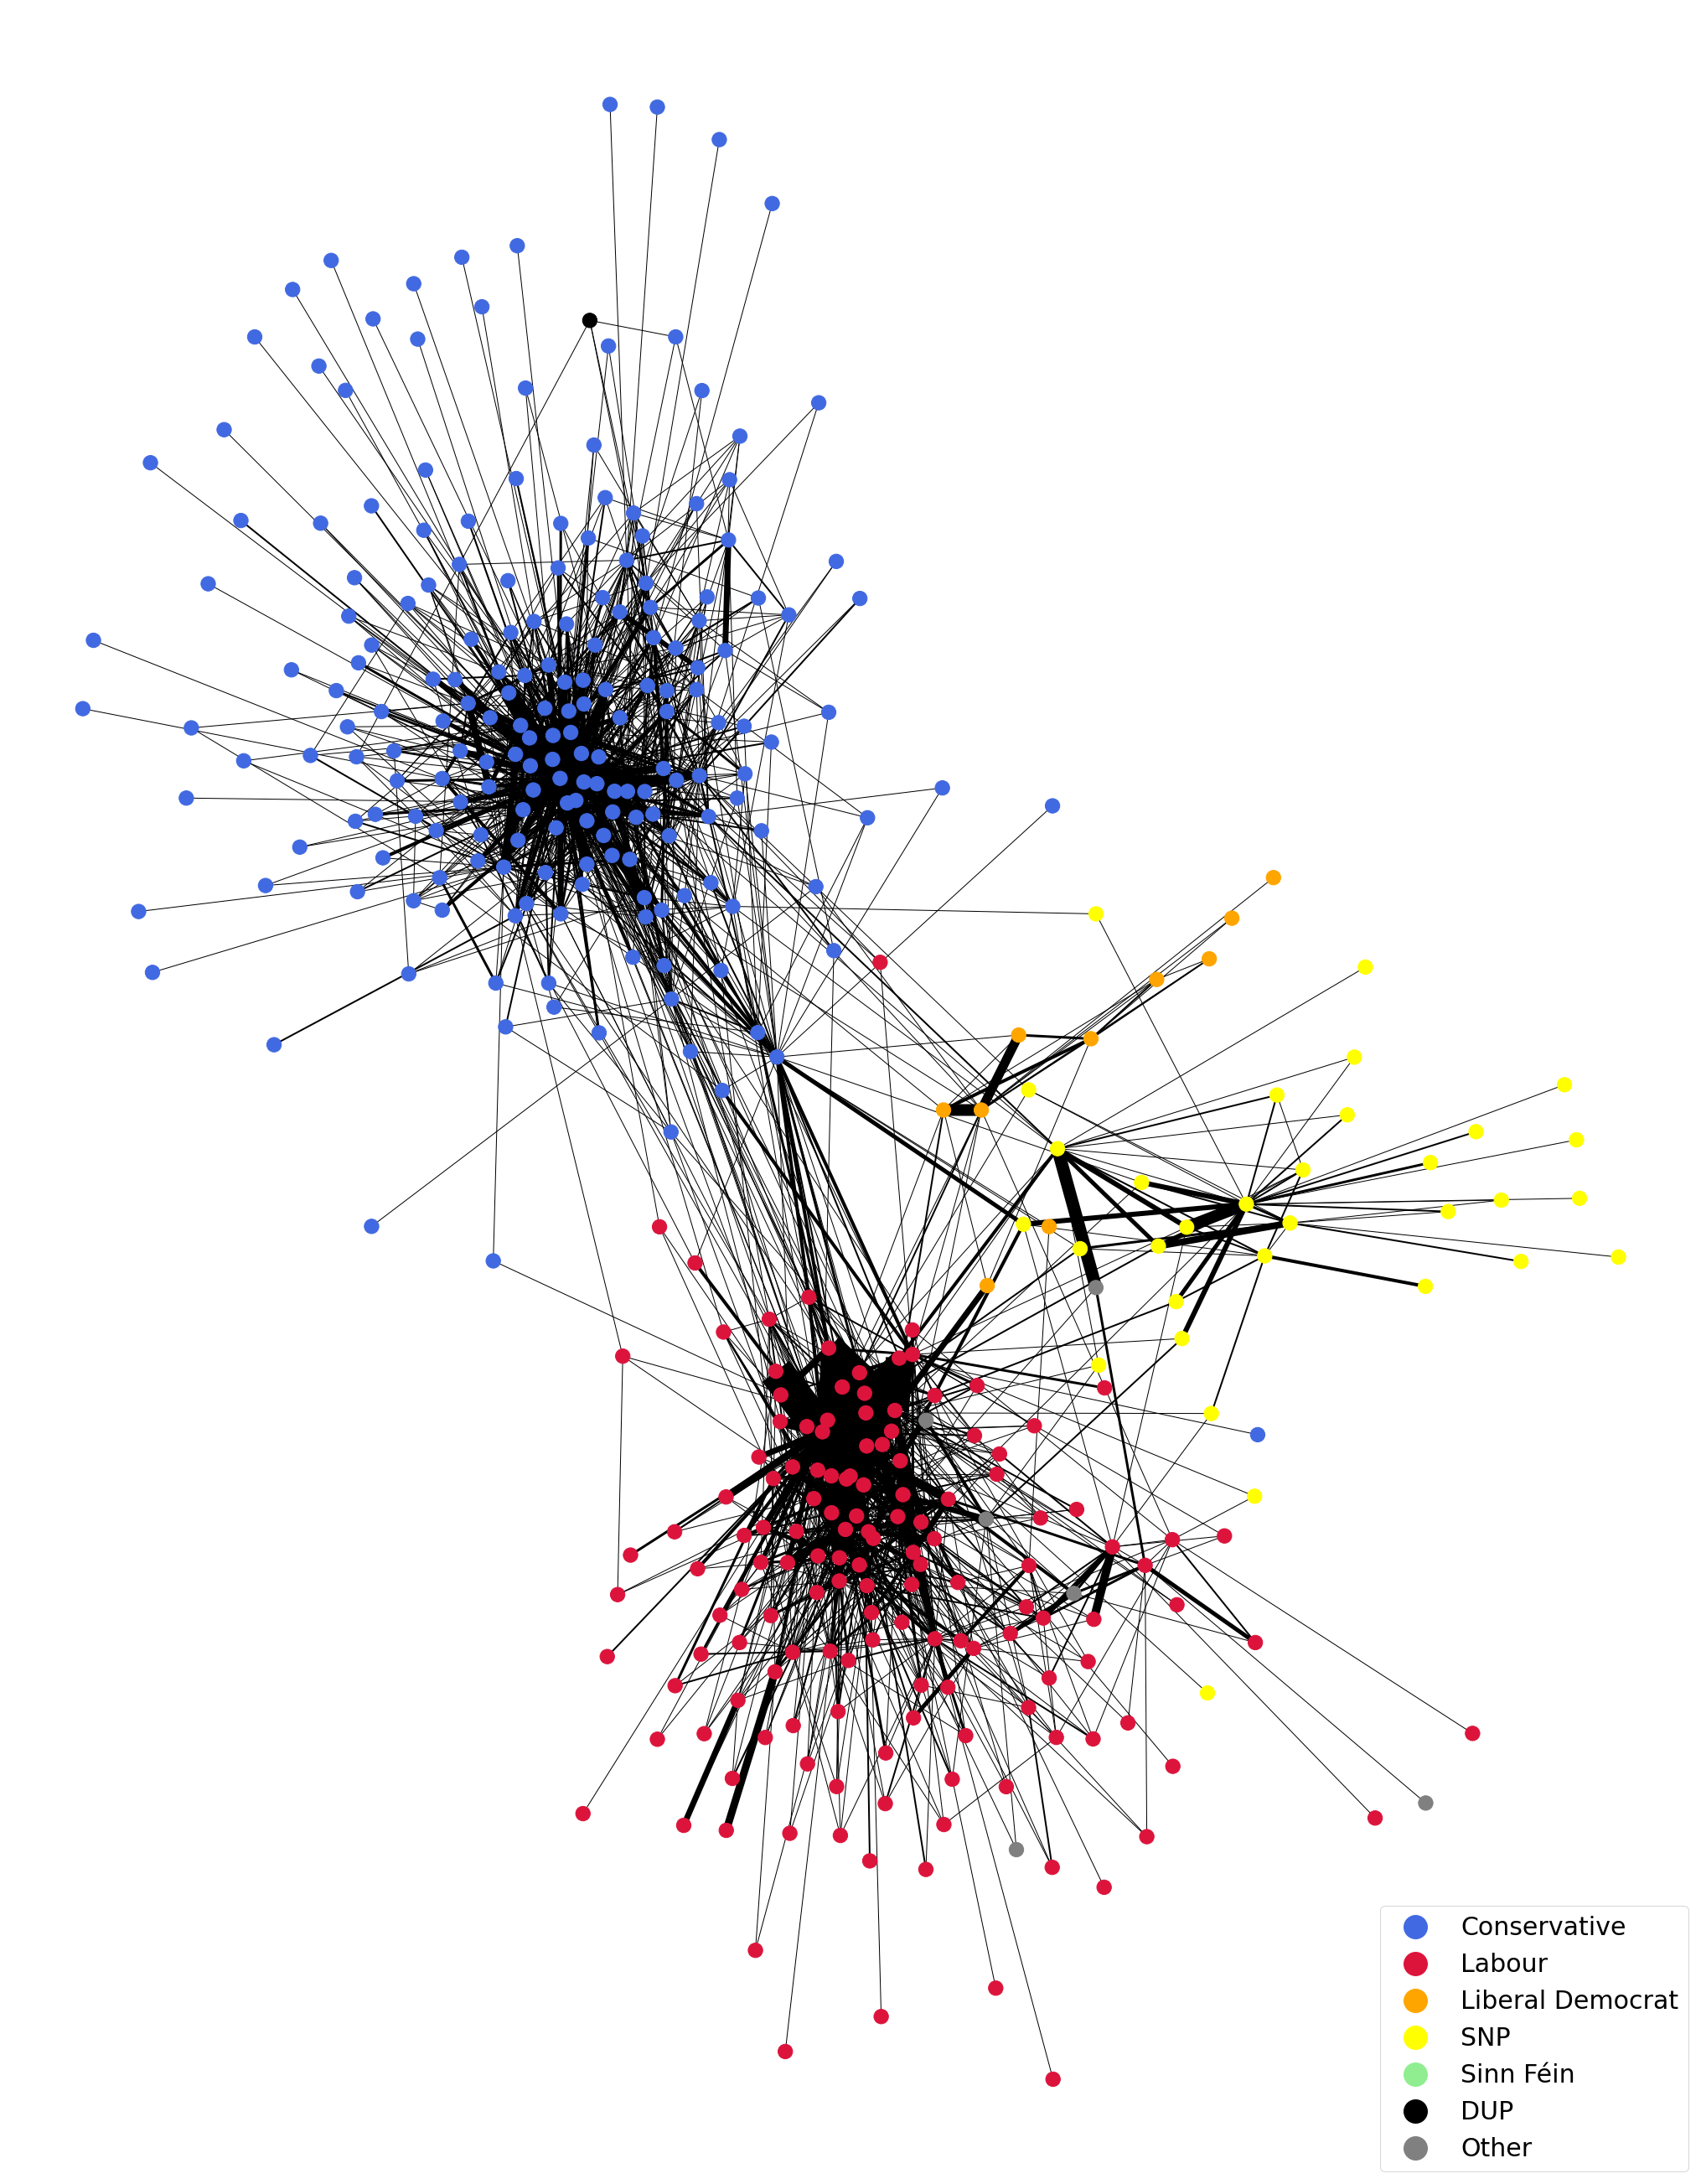

In [16]:
#edgelist    
edges = list(zip(df.mp_screen_name, df.liked_screen_name))
#blank graph    
G = nx.Graph() 
#add edges weighted by number of occurances
G.add_edges_from((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())
# party node attribute
nx.set_node_attributes(G, name='party',values=mp_details['party'])
# Focus in on main network - normally excludes Sinn Fein MPs
for component in list(nx.connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)
#thickness of edge lines based on weight
weight = [G[u][v]['weight'] for u,v in G.edges] 
# party colours
color_map = []
for node in G.nodes:
    if G.nodes[node]['party'] == 'Conservative':
        color_map.append('royalblue')
    elif G.nodes[node]['party'] == 'Labour': 
        color_map.append('crimson') 
    elif G.nodes[node]['party'] == 'Liberal Democrat': 
        color_map.append('orange') 
    elif G.nodes[node]['party'] == 'Scottish National Party': 
        color_map.append('yellow') 
    elif G.nodes[node]['party'] =='Sinn Féin ': 
        color_map.append('lightgreen')
    elif G.nodes[node]['party'] =='Democratic Unionist Party': 
        color_map.append('black')
    else: color_map.append('grey')
#layout algorithum
pos = nx.fruchterman_reingold_layout(G,iterations=200)
#legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Conservative',
                          markerfacecolor='royalblue', markersize=30),
                   Line2D([0], [0], marker='o', color='w', label='Labour',
                          markerfacecolor='crimson', markersize=30), 
                   Line2D([0], [0], marker='o', color='w', label='Liberal Democrat',
                          markerfacecolor='orange', markersize=30), 
                   Line2D([0], [0], marker='o', color='w', label='SNP',
                          markerfacecolor='yellow', markersize=30), 
                   Line2D([0], [0], marker='o', color='w', label='Sinn Féin',
                          markerfacecolor='lightgreen', markersize=30), 
                   Line2D([0], [0], marker='o', color='w', label='DUP',
                          markerfacecolor='black', markersize=30), 
                   Line2D([0], [0], marker='o', color='w', label='Other',
                          markerfacecolor='grey', markersize=30)]
# plotting the network
fig = matplotlib.pyplot.figure(1, figsize=(28, 36))
fig.legend(handles=legend_elements, loc='lower right', fontsize= '30')
nx.draw(G, pos=pos, node_size = 300, with_labels=False, 
        node_color = color_map, width=weight)
matplotlib.pyplot.show() 


As can be seen, the interactions of MPs on Twitter is highly partisan - MPs tend to interact with other MPs of their own party. However, this is not the whole story, For example the SNP seem to interact more with Labour due to their ideological similarity and the Liberal Democrats interact with both Labour and the Conservatives. 

This network can then be analysed and hypotheses tested. Important to note that likes are only one type of interaction. For my dissertation I also collected retweets. Other interactions like mentions could be used.